<a href="https://colab.research.google.com/github/gnitnaw/Programs/blob/master/Chapter4/EMclust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version
!rm clusterdata.*
!wget https://raw.github.com/gnitnaw/Programs/master/Chapter4/clusterdata.csv

Python 3.7.12
--2021-11-03 14:43:42--  https://raw.github.com/gnitnaw/Programs/master/Chapter4/clusterdata.csv
Resolving raw.github.com (raw.github.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/gnitnaw/Programs/master/Chapter4/clusterdata.csv [following]
--2021-11-03 14:43:42--  https://raw.githubusercontent.com/gnitnaw/Programs/master/Chapter4/clusterdata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4832 (4.7K) [text/plain]
Saving to: ‘clusterdata.csv’

clusterdata.csv     100%[===================>]   4.72K  --.-KB/s    in 0s      

2021-11-03 14:43:

# Example 4.5
## Import modules

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
print(np.__version__)

1.19.5


## Set random seed

In [3]:
np.random.seed(120)

## Additional Function

In [4]:
def confidence_ellipse_pure(mu, cov, ax, n_std=1.96, facecolor='none', **kwargs):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mu[0], mu[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def confidence_ellipse(x, y, ax, n_std=1.96, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

## Original Program

In [5]:
Xmat = np.genfromtxt('clusterdata.csv', delimiter=',')
K = 3
n, D = Xmat.shape

W = np.array([[1/3,1/3,1/3]])
M  = np.array([[-2.0,-4,0],[-3,1,-1]])  #stores the mu's as columns
C = np.zeros((3,2,2))

C[:,0,0] = 1
C[:,1,1] = 1

p = np.zeros((3,300))

labels = np.zeros(300, dtype=int)
for i in range(0,100): 

    for k in range(0,K):    #E-step
        mvn = multivariate_normal( M[:,k].T, C[k,:,:] )
        p[k,:] = W[0,k]*mvn.pdf(Xmat)

    # M-step
    p = p/sum(p,0)   #normalize
    W = np.mean(p,1).reshape(1,3)
    for k in range(0,K):
        M[:,k] = (Xmat.T @ p[k,:].T)/sum(p[k,:])
        xm = Xmat.T - M[:,k].reshape(2,1)
        C[k,:,:] = xm @ (xm*p[k,:]).T/sum(p[k,:])

for i in range(300):
    if p[0][i]>p[1][i] : #0>1
        if p[0][i]>p[2][i] : #0>1,2
            labels[i] = 0
        else : #0>1, 2>0
            labels[i] = 2
    else : # 1>0
        if p[1][i]>p[2][i] : #1>0,2
            labels[i] = 1
        else : # 1>0, 2>1
            labels[i] = 2

WW = np.zeros(3)

for i in range(300):
    WW[labels[i]] = WW[labels[i]]+1
print(W)
#print(labels)
print(mvn.pdf(Xmat).shape)
print(WW/300.0)
print(np.mean(p,1))

[[0.33033004 0.32063338 0.34903658]]
(300,)
[0.33 0.33 0.34]
[0.33033004 0.32063338 0.34903658]


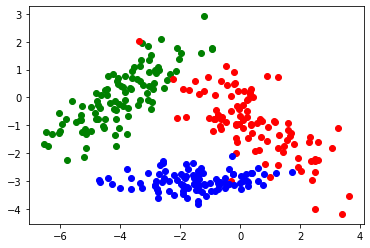

In [6]:
plt.plot(Xmat[:100, 0],Xmat[:100, 1], 'go')
plt.plot(Xmat[100:200, 0],Xmat[100:200, 1], 'ro')
plt.plot(Xmat[200:300, 0],Xmat[200:300, 1], 'bo')
plt.show()

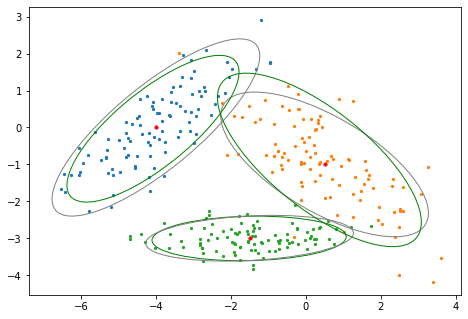

In [7]:
Mu = np.array([[-4, 0], [0.5, -1], [-1.5, -3]])
Cov = np.array([[[2.0, 1.4],
                [1.4, 1.5]],
               [[2.0, -0.95],
                [-0.95, 1]],
               [[2.0, 0.1],
                [0.1, 0.1]]] )

scale = 1, 1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i in range(3):
    x = Xmat[100*i:100*(i+1), 0]
    y = Xmat[100*i:100*(i+1), 1]
    ax.scatter(x, y, s=5)
    confidence_ellipse_pure(Mu[i], Cov[i], ax, edgecolor='grey')
    confidence_ellipse_pure(M.T[i], C[i], ax, edgecolor='green')
    ax.scatter(Mu[i][0], Mu[i][1], c='red', s=10)

plt.show()